# Simulation

## Data

The variables $X_1, X_2, X_3$ are sampled as follows.

- $X_1 \sim \mathcal{B}(1, 0.8)$
- $X_2 \sim \mathcal{B}(1, 0.4)$
- $X_3 \sim \mathcal{B}(1, 0.6)$

The dependent variable $y$ is sampled as follows.

- $z = 2.0 + 0.5 X_1 + 0.8 X_1 X_2 X_3$
- $p = \dfrac{1.0}{1.0 + \exp(-z)}$
- $y \sim \mathcal{B}(1, p)$

The design matrix $X$ is composed of the following variables and interactions.

- $X_1$
- $X_2$
- $X_3$
- $X_1 X_2$
- $X_1 X_3$
- $X_2 X_3$
- $X_1 X_2 X_3$

There are 1,000 sampled data points.

In [1]:
import numpy as np
import random
from scipy.stats import binom

random.seed(37)
np.random.seed(37)

N = 1_000

x1 = np.random.binomial(1, 0.8, N)
x2 = np.random.binomial(1, 0.4, N)
x3 = np.random.binomial(1, 0.6, N)
x1x2 = x1 * x2
x1x3 = x1 * x3
x2x3 = x2 * x3
x1x2x3 = x1 * x2 * x3

X = np.hstack((
    x1.reshape(-1, 1), 
    x2.reshape(-1, 1), 
    x3.reshape(-1, 1),
    x1x2.reshape(-1, 1),
    x1x3.reshape(-1, 1),
    x2x3.reshape(-1, 1),
    x1x2x3.reshape(-1, 1)
))

z = 2.0 + 0.5 * x1 + 0.8 * x1x2x3
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)

In [2]:
X.shape, y.shape

((1000, 7), (1000,))

## Logistic regression

Logistic regression is applied to the data with the following regularization.

- none
- `L1` (Lasso)
- `L2` (Ridge) 
- ElasticNet

More [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is available.

### None

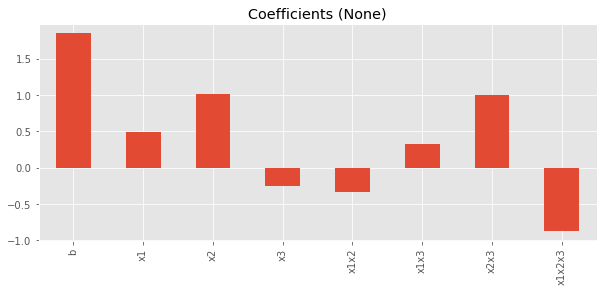

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')

def get_model(reg='none'):
    if reg == 'l1':
        model = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=37)
    elif reg == 'l2':
        model = LogisticRegression(penalty='l2', solver='saga', random_state=37)
    elif reg == 'elasticnet':
        model = LogisticRegression(penalty='elasticnet', l1_ratio=0.6, solver='saga', random_state=37)
    else:
        model = LogisticRegression(penalty='none', solver='saga', random_state=37, max_iter=10_000)
    
    return model

def get_coef(m):
    coefs = [m.intercept_[0]] + list(m.coef_[0])
    cols = ['b', 'x1', 'x2', 'x3', 'x1x2', 'x1x3', 'x2x3', 'x1x2x3']
    return pd.Series(coefs, index=cols)

model = get_model('none')
model.fit(X, y)

_ = get_coef(model).plot(kind='bar', figsize=(10, 4), title=r'Coefficients (None)')

In [4]:
import scipy.stats


def get_color(s, n=10):
    if s.loc['alpha=0.1']:
        return ['background-color: rgb(255, 0, 0, 0.18)'] * n
    else:
        return [None] * n
    
def do_lreg(df, reg='none'):
    sample = df.sample(df.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'y']]
    y_tr = sample.y

    lr = LogisticRegression(penalty='l2', solver='liblinear')
    lr.fit(X_tr, y_tr)

    params = [lr.intercept_[0]] +  list(lr.coef_[0])

    return params

def get_se(X, y, reg='none', index=['b', 'x1', 'x2', 'x3', 'x1x2', 'x1x3', 'x2x3', 'x1x2x3']):
    lr = get_model(reg=reg)
    lr.fit(X, y)

    df = pd.DataFrame(X)
    df['y'] = y

    r_df = pd.DataFrame([do_lreg(df, reg=reg) for _ in range(100)])

    w = [lr.intercept_[0]] + list(lr.coef_[0])
    se = r_df.std()

    dof = X.shape[0] - X.shape[1] - 1

    summary = pd.DataFrame({
        'w': w,
        'se': se,
        'z': w / se,
        '.025': w - se,
        '.975': w + se,
        'df': [dof for _ in range(len(w))]
    })

    summary['P>|z|'] = scipy.stats.t.sf(abs(summary.z), df=summary.df)
    summary['alpha=0.1'] = summary['P>|z|'].apply(lambda p: p <= 0.1)
    summary['alpha=0.05'] = summary['P>|z|'].apply(lambda p: p <= 0.05)
    summary['alpha=0.01'] = summary['P>|z|'].apply(lambda p: p <= 0.01)
    summary.index = index

    return summary.style.apply(get_color, axis=1)

get_se(X, y, reg='none')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,1.845553,0.235824,7.825968,1.609729,2.081377,992,0.000000,True,True,True
x1,0.497434,0.302584,1.643951,0.194849,0.800018,992,0.050252,True,False,False
x2,1.017254,0.298621,3.406507,0.718633,1.315875,992,0.000342,True,True,True
x3,-0.251535,0.311342,-0.807905,-0.562876,0.059807,992,0.209669,False,False,False
x1x2,-0.331826,0.344670,-0.962735,-0.676495,0.012844,992,0.167957,False,False,False
x1x3,0.332592,0.373780,0.889805,-0.041189,0.706372,992,0.186893,False,False,False
x2x3,0.998870,0.357213,2.796282,0.641656,1.356083,992,0.002635,True,True,True
x1x2x3,-0.872408,0.365408,-2.387489,-1.237816,-0.507000,992,0.008575,True,True,True


### Lasso

For Lasso, we set `C=0.5` (smaller values of C means stronger regularization). 

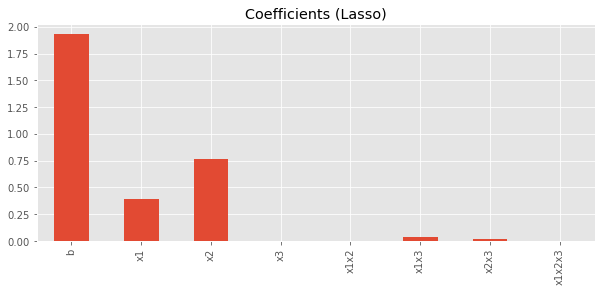

In [5]:
model = get_model('l1')
model.fit(X, y)

_ = get_coef(model).plot(kind='bar', figsize=(10, 4), title=r'Coefficients (Lasso)')

In [6]:
get_se(X, y, reg='l1')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,1.932348,0.247872,7.795739,1.684476,2.180220,992,0.000000,True,True,True
x1,0.389334,0.288420,1.349884,0.100914,0.677754,992,0.088681,True,False,False
x2,0.766469,0.341255,2.246030,0.425214,1.107724,992,0.012461,True,True,False
x3,0.000000,0.318163,0.000000,-0.318163,0.318163,992,0.500000,False,False,False
x1x2,0.000000,0.365351,0.000000,-0.365351,0.365351,992,0.500000,False,False,False
x1x3,0.042119,0.337480,0.124806,-0.295360,0.379599,992,0.450351,False,False,False
x2x3,0.014868,0.338276,0.043952,-0.323408,0.353144,992,0.482476,False,False,False
x1x2x3,0.000000,0.330758,0.000000,-0.330758,0.330758,992,0.500000,False,False,False


## Ridge

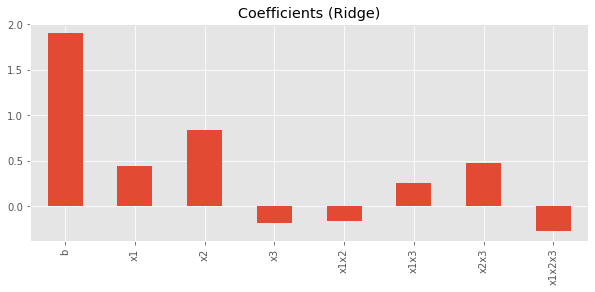

In [7]:
model = get_model('l2')
model.fit(X, y)

_ = get_coef(model).plot(kind='bar', figsize=(10, 4), title=r'Coefficients (Ridge)')

In [8]:
get_se(X, y, reg='l2')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,1.896089,0.272440,6.959659,1.623649,2.168529,992,0.000000,True,True,True
x1,0.441485,0.280298,1.575055,0.161187,0.721783,992,0.057781,True,False,False
x2,0.839984,0.332033,2.529823,0.507951,1.172017,992,0.005783,True,True,True
x3,-0.187457,0.295768,-0.633799,-0.483225,0.108311,992,0.263179,False,False,False
x1x2,-0.167678,0.386074,-0.434315,-0.553752,0.218396,992,0.332077,False,False,False
x1x3,0.250347,0.337761,0.741194,-0.087414,0.588108,992,0.229376,False,False,False
x2x3,0.479378,0.337542,1.420203,0.141836,0.816920,992,0.077931,True,False,False
x1x2x3,-0.274651,0.385936,-0.711647,-0.660587,0.111286,992,0.238425,False,False,False


### Elasticnet

Take note of the `l1_ratio`; a value closer to 0 favors Ridge and a value closer to 1 favors Lasso.

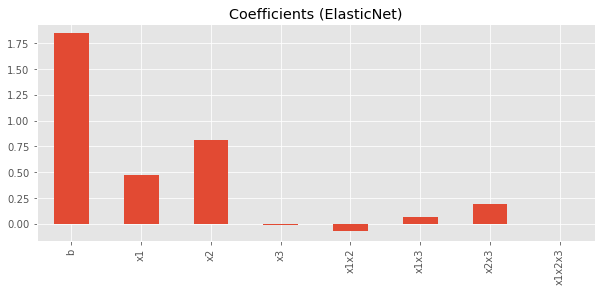

In [9]:
model = get_model('elasticnet')
model.fit(X, y)

_ = get_coef(model).plot(kind='bar', figsize=(10, 4), title=r'Coefficients (ElasticNet)')

In [10]:
get_se(X, y, reg='elasticnet')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,1.843908,0.288977,6.380801,1.554930,2.132885,992,0.000000,True,True,True
x1,0.476937,0.309807,1.539465,0.167130,0.786744,992,0.062005,True,False,False
x2,0.810442,0.332081,2.440494,0.478361,1.142523,992,0.007421,True,True,True
x3,-0.014077,0.301135,-0.046747,-0.315212,0.287058,992,0.481362,False,False,False
x1x2,-0.070456,0.350944,-0.200762,-0.421401,0.280488,992,0.420463,False,False,False
x1x3,0.069566,0.379090,0.183507,-0.309524,0.448656,992,0.427219,False,False,False
x2x3,0.187912,0.313433,0.599528,-0.125521,0.501344,992,0.274479,False,False,False
x1x2x3,0.000000,0.390010,0.000000,-0.390010,0.390010,992,0.500000,False,False,False
